In [35]:
import numpy as np
import matplotlib
from IPython.display import clear_output
import scipy

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [46]:
input = np.load('initial_data/function_1/initial_inputs.npy')
Z = np.load('initial_data/function_1/initial_outputs.npy')
X = input[:,0]
Y = input[:,1]

In [97]:
print(X, Y, Z)

[0.31940389 0.57432921 0.73102363 0.84035342 0.65011406 0.41043714
 0.31269116 0.68341817 0.08250725 0.88388983] [0.76295937 0.8798981  0.73299988 0.26473161 0.68152635 0.1475543
 0.07872278 0.86105746 0.40348751 0.58225397] [ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048]


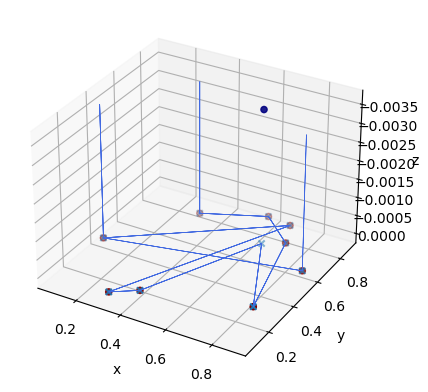

In [99]:
cm = matplotlib.pyplot.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=min(Z), vmax=max(Z))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z, c=scalarMap.to_rgba(Z))
ax.scatter(X, Y, 0, marker='x')
ax.set_zlim(ax.get_zlim()[::-1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
scalarMap.set_array(Z)
matplotlib.pyplot.show()

In [105]:
axis = np.linspace(0, 1, 101).reshape(-1, 1)
mesh = []
for i in axis:
    row = []
    for j in axis:
        row.append((i[0], j[0]))
    mesh.append(row)
mesh = np.array(mesh)
np.shape(mesh)

(101, 101, 2)

In [106]:
mesh = mesh.reshape(-1,2)

(10201,)
Data so far (sorted by descending observations): 
1: (x, y, f(x)) = ('0.319404', '0.762959', '0.000000000000000000000000000000')
2: (x, y, f(x)) = ('0.574329', '0.879898', '0.000000000000000000000000000000')
3: (x, y, f(x)) = ('0.731024', '0.733000', '0.000000000000000771087511450285')
4: (x, y, f(x)) = ('0.840353', '0.264732', '0.000000000000000000000000000000')
5: (x, y, f(x)) = ('0.650114', '0.681526', '-0.003606062644363476361181186647')
6: (x, y, f(x)) = ('0.410437', '0.147554', '-0.000000000000000000000000000000')
7: (x, y, f(x)) = ('0.312691', '0.078723', '-0.000000000000000000000000000000')
8: (x, y, f(x)) = ('0.683418', '0.861057', '0.000000000000000000000000000000')
9: (x, y, f(x)) = ('0.082507', '0.403488', '0.000000000000000000000000000000')
10: (x, y, f(x)) = ('0.883890', '0.582254', '0.000000000000000000000000000000')
[0.65 0.68]


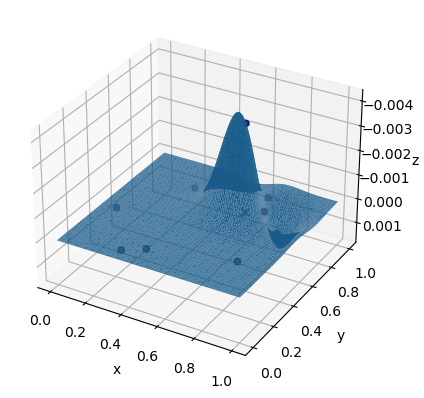

In [118]:
# Parameters of the problem. Feel free to change them and play around with them
real_noise_std = 1e-10 # needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10

rbf_lengthscale = 0.1
pi_explore = 0.2

# define kernel of GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)


# how many queries in optimisation loop?
num_queries = 10

#define normal cdf function
def normcdf(x, mean, std, explore=0):
    results = []
    for index in range(0, len(mean)):
        results.append(1-scipy.stats.norm(mean[index], std[index]).cdf(x + explore))# * std[index]))
    return results

# clear outputs, to keep interface clean
clear_output(wait = True)
# fit model
model.fit(np.array(input).reshape(-1, 2), np.array(Z).reshape(-1, 1))
# calculate mean and standard devation, make them one-dimensional for plotting
post_mean, post_std = model.predict(mesh, return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()
print(post_mean.shape)

# select display format of X and Y
X_format = ['%.6f' % query for query in X] # 6 sig figs
Y_format = ['%.6f' % obs for obs in Y] # 6 sig figs
Z_format = ['%.30f' % obs for obs in Z] # 6 sig figs

data = [(x, y, z) for x, y, z in zip(X_format, Y_format, Z_format)]
print('Data so far (sorted by descending observations): ')
print('\n'.join('{}: (x, y, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) # display data
#_ = input('Input anything to see the next chosen point') # we are using this to allow for the user to change plots

# MODIFY THE CODE IN THIS AREA
#######################################################
#acquisition_function = post_mean + beta * post_std
acquisition_function = post_std * post_std
#acquisition_function = normcdf(max_obs, mean=post_mean, std=post_std)
#acquisition_function = normcdf(min(Z), mean=post_mean, std=post_std, explore=pi_explore)
#######################################################

x = mesh[np.argmin(acquisition_function)]
print(x)

cm = matplotlib.pyplot.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=min(Z), vmax=max(Z))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z, c=scalarMap.to_rgba(Z))
ax.scatter(X, Y, 0, marker='x')
ax.plot_trisurf(mesh[:,0], mesh[:,1], post_mean)
ax.plot(x[0], x[1], 0, marker='x', color='green')
ax.set_zlim(ax.get_zlim()[::-1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
scalarMap.set_array(Z)
matplotlib.pyplot.show()